In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import math
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [2]:
#Function to convert GPS time to milliseconds
#The base time is the RTC time in milliseconds that corresponds with the first GPS time stamp
def timeToMillis(time, RTC_millis):
    sec = np.zeros(time.size)
    sec = sec.astype(int)
    minutes = np.zeros(time.size)
    minutes = minutes.astype(int)
    hours = np.zeros(time.size)
    hours = hours.astype(int)
    for i in range(0, time.size):
        sec[i] = time[i]%100
    for i in range(0, time.size):
        minutes[i] = (time[i]%10000 - time[i]%100)/100
    for i in range(0, time.size):
        hours[i] = (time[i] - time[i]%10000)/10000

    GPS_millis = np.zeros(time.size)
    GPS_millis = GPS_millis.astype(int)
    GPS_millis[0] = RTC_millis[0]
    for i in range (1, time.size):
        if (sec[i] > sec[i - 1]):
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1])*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (60 + minutes[i] - minutes[i - 1])*60*1000            
        else:
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1] - 1)*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (59 + minutes[i] - minutes[i - 1])*60*1000            
    return GPS_millis


#Function to convert time in milliseconds to digital time 
#Used to convert both GPS time in milliseconds and RTC time in milliseconds to digital time 
#The base time is taken as the first GPS time stamp
def millisToTime(millis, time):
    mil = millis/1000
    time_temp = np.zeros(time.size)
    hours = np.zeros(time_temp.size)
    minutes = np.zeros(time_temp.size)
    seconds = np.zeros(time_temp.size)
    time_temp[0] = time[0]
    for i in range (1, time.size):
        seconds[i] = time_temp[i - 1]%100 + (mil[i] - mil[i - 1])
        if (seconds[i] > 60):
            temp_minutes = 0
            while (seconds[i] >= 60):
                temp_minutes += 100
                seconds[i] = seconds[i] - 60
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + temp_minutes
        elif (seconds[i] == 60):
            seconds[i] = 0
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + 100
        else:
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100)
        if (minutes[i] > 5900):
            minutes[i] = 6000 - minutes[i]
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000) + 10000
        else:
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000)
        if (hours[i] > 230000):
            hours[i] = 240000 - hours[i]
        time_temp[i] = hours[i] + minutes[i] + seconds[i]

    #Split time with colons
    output_time = [0 for i in range(time_temp.size)]
    hours_temp = np.zeros(time_temp.size)
    minutes_temp = np.zeros(time_temp.size)
    seconds_temp = np.zeros(time_temp.size)
    for i in range (0, time_temp.size):
        hours_temp[i] = int((time_temp[i] - time_temp[i]%10000)/10000)
        minutes_temp[i] = int((time_temp[i]%10000 - time_temp[i]%100)/100)
        seconds_temp[i] = time_temp[i]%100
        if (seconds_temp[i] < 10):
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
            else:
                output_time[i] = "%d:%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
        else:
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])  
            else:
                output_time[i] = "%d:%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
    return output_time 

#Split data into training and testing sets (0.8/0.2)
def dataSplit(x_millis, y_millis):
    x_train, x_test, y_train, y_test = train_test_split(x_millis, y_millis, test_size=0.2, random_state=1)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)
    return x_train.reshape(-1,1), y_train.reshape(-1,1), x_test.reshape(-1,1), y_test.reshape(-1,1), x_val.reshape(-1,1), y_val.reshape(-1,1)


#Metrics for regression analysis
def RMSE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = (y[i] - predict[i])**2
    return np.sqrt((np.sum(c))/len(c))

def MAE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = abs(y[i] - predict[i])
    return (np.sum(c))/len(c)

#Metrics related to clock AccOffset 
def plotDrift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    t = np.linspace(50000, len(GPS_millis[50000:len(GPS_millis)]), len(GPS_millis[50000:len(GPS_millis)]))
    plt.plot(t, Drift[50000:len(GPS_millis)])
    plt.title('Frequency of clock drift of Teensy internal RTC (ppm)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Drift (ppm)')
    plt.show()

def plotOffset(GPS_millis, RTC_millis):
    offset = np.zeros(GPS_millis.size)
    offsetsum = 0
    for i in range(0, GPS_millis.size):
        offset[i] = (GPS_millis[i] - offsetsum - RTC_millis[i])
        offsetsum = np.sum(offset)
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, offset)
    plt.title('Clock offset of internal Teensy RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Clock offset (ms)')
    plt.show()
    

def plotAccOffset(GPS_millis, RTC_millis):
    AccOffset = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        AccOffset[i] = (GPS_millis[i] - RTC_millis[i])
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, AccOffset)
    plt.title('Accumulated offset of Teensy internal RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Accumulated offset (ms)')
    plt.show()
    
def AccOffset(GPS_millis, RTC_millis):
    d = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        d[i] = (GPS_millis[i] - RTC_millis[i])
    return d

def Drift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    return Drift

def convertToCycles(array):
    a = np.zeros(array.size)
    for i in range(0, array.size):
        a[i] = (array[i]/1000)*32768
    return a

#dataframe to summarise linear regression metrics
def RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model):
    predict1 = model.predict(x1_train)
    r1 =  model.score(x1_train, y1_train)
    rmse1 = RMSE(predict1, y1_train)
    mae1 =  MAE(predict1, y1_train)
    
    predict2 = model.predict(x1_test)
    r2 = model.score(x1_test, y1_test)
    rmse2 = RMSE(predict2, y1_test)
    mae2 = MAE(predict2, y1_test)
    
    predict3 = model.predict(x1_val)
    r3 = model.score(x1_val, y1_val)
    rmse3 = RMSE(predict3, y1_val)
    mae3 = MAE(predict3, y1_val)
    
    d = {'Index Title': ['Training', 'Validation', 'Test'],'R': [r1, r3, r2], 'RMSE' : [rmse1, rmse3, rmse2], 'MAE' :[mae1, mae3, mae2]}
    df = pd.DataFrame(d).set_index('Index Title')
    return display(df)


#Data Frames to summarise metrics for testing sets and display synchronised time
def synch(RTC_millis, GPS_millis, model, time, AccOffset):
    millis_predict = model.predict(RTC_millis.reshape(-1, 1))
    #Convert AccOffset prediction to synchronised time by adding the AccOffset to RTC time in milliseconds
    for i in range (0, millis_predict.size):
        millis_predict[i] = RTC_millis[i] + millis_predict[i]
    millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
    r =  model.score(RTC_millis.reshape(-1, 1), AccOffset.reshape(-1, 1))
    rmse =  RMSE(millis_predict, GPS_millis)
    mae = MAE(millis_predict, GPS_millis)
    
    d = {'R': [r], 'RMSE' : [rmse], 'MAE' :[mae]}
    d = pd.DataFrame(d)
    display(d)
    df = pd.DataFrame({'GPS Time (ms)': GPS_millis, 'RTC Time (ms)': RTC_millis, 
                         'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis, time),
                           'RTC Time':millisToTime(RTC_millis, time), 'Synch Time' : millisToTime(millis_predict, time)})
    return display(df)

In [24]:
#Reading data from training run of sensor 1
with open('DS3231.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('DS3231.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data1 = pd.read_csv("DS3231.csv")
data_arr1 = np.array(data1)
time1 = data_arr1[0:,1]
#RTC_millis1 = data_arr1[0:,5]
temp1 = data_arr1[0:,6]
offset1 = data_arr1[0:,7]
num1 = data_arr1[0:,8]

#for i in range(0, 131032):
#    RTC_millis1[i] = (RTC_millis1[i]- 26*(32768) - 27401)/32768
#RTC_millis1[131032] = 32768  
#for i in range(131033, RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i] + 3380
#for i in range(131032, RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i]/32768 + RTC_millis1[131031]
#for i in range(RTC_millis1.size):
#    RTC_millis1[i] = RTC_millis1[i]*1000

RTC_millis1 = np.zeros(offset1.size)
for i in range(0, offset1.size):
    RTC_millis1[i] = offset1[i] + RTC_millis1[i - 1]
for i in range(0, offset1.size):
    RTC_millis1[i] = (RTC_millis1[i]/32768)*1000

In [25]:
#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis1 = timeToMillis(time1, RTC_millis1)

#Determining the AccOffset of all three sensors
AccOffset1 = AccOffset(GPS_millis1, RTC_millis1)

#Splitting the training and testing data only for the first sensor (on which the model is built and tested)
x1_train, y1_train, x1_test, y1_test, x1_val, y1_val = dataSplit(RTC_millis1, AccOffset1)

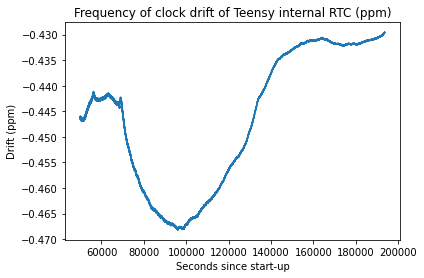

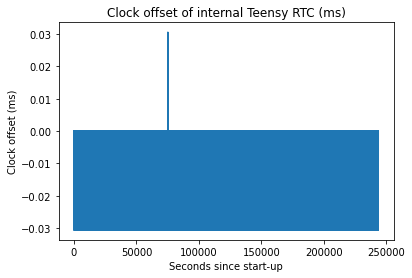

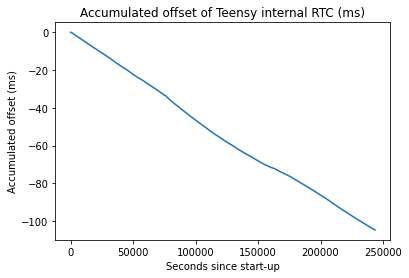

In [26]:
plotDrift(GPS_millis1, RTC_millis1)
plotOffset(GPS_millis1, RTC_millis1)
plotAccOffset(GPS_millis1, RTC_millis1)


In [27]:
print('RMSE Testing Sensor One: ', RMSE(RTC_millis1, GPS_millis1))
print('MAE Testing Sensor One:', MAE(RTC_millis1, GPS_millis1))

RMSE Testing Sensor One:  61.89644991533858
MAE Testing Sensor One: 53.96434943066533


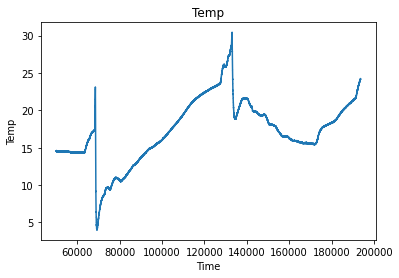

In [28]:
t = np.linspace(50000, len(temp1[50000:len(temp1)]), len(temp1[50000:len(temp1)]))
plt.plot(t, temp1[50000:len(temp1)])
plt.title('Temp')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.show()

In [29]:
drift = Drift(GPS_millis1, RTC_millis1)
accOffset = AccOffset(GPS_millis1, RTC_millis1)

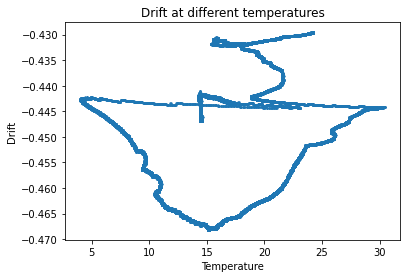

In [32]:
plt.scatter(temp1[50000:temp1.size], drift[50000:temp1.size], s = 2)
plt.title('Drift at different temperatures')
plt.xlabel('Temperature')
plt.ylabel('Drift')
plt.show()


In [33]:
print('Mean drift:', np.mean(drift))
print('Mean accumulated offset:', np.mean(accOffset))
print('Mean temperature:', np.mean(temp1))

Mean drift: -0.4438549580874125
Mean accumulated offset: -53.96434943066533
Mean temperature: 16.757160581494066


In [34]:
# Linear Regression
model1 = LinearRegression().fit(x1_train, y1_train)
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, model1, time1, accOffset)
#synch.to_csv(r'C:\Users\suben\Documents\Priyanka\Skripsie\synch1.csv', index = False)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.997357,1.557791,1.394750
Validation,0.997359,1.563732,1.402502
Test,0.997348,1.560839,1.397835


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.997356,1.659345,1.537668


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,998,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,1998,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,2998,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,3998,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,4998,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243685998,6:53:54.000,6:53:54.105,6:53:54.000
243648,243687000,2.436871e+08,243686998,6:53:55.000,6:53:55.105,6:53:55.000
243649,243688000,2.436881e+08,243687998,6:53:56.000,6:53:56.105,6:53:56.000
243650,243689000,2.436891e+08,243688998,6:53:57.000,6:53:57.105,6:53:57.000


In [35]:
net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
print("Performance of model on training set")
RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, net1)
print("Synchronised time: Training set Sensor 1")
synch(RTC_millis1, GPS_millis1, net1, time1, accOffset)

Performance of model on training set


,R,RMSE,MAE
Index Title,,,
Training,0.996563,1.776462,1.430493
Validation,0.996574,1.781080,1.433885
Test,0.996546,1.781527,1.435063


Synchronised time: Training set Sensor 1


,R,RMSE,MAE
0,0.996562,1.773789,1.349732


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,1000,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,2000,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,3000,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,4000,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,5000,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243685997,6:53:54.000,6:53:54.105,6:53:53.997
243648,243687000,2.436871e+08,243686997,6:53:55.000,6:53:55.105,6:53:54.997
243649,243688000,2.436881e+08,243687997,6:53:56.000,6:53:56.105,6:53:55.997
243650,243689000,2.436891e+08,243688997,6:53:57.000,6:53:57.105,6:53:56.997


In [11]:
error = np.zeros(6)
for i in range(1, 6):
    net1 = MLPRegressor(alpha = 1e-4, solver = 'adam', random_state =1,
                  learning_rate_init = 0.1/(10*i)).fit(x1_train, np.reshape(y1_train, len(y1_train)))
    predict = net1.predict(x1_val)
    error[i - 1] = RMSE(predict, y1_val)

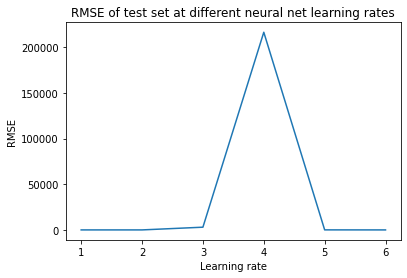

In [12]:
t = np.linspace(1, 6, 6)
plt.plot(t, error)
plt.title('RMSE of test set at different neural net learning rates')
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.show()

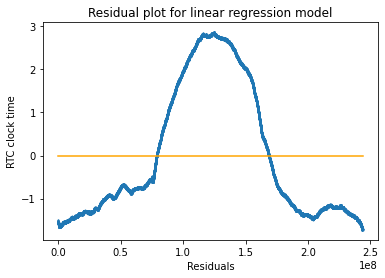

In [36]:
predict1 = model1.predict(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(y1_val.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0, max(x1_val))
z = np.zeros(50)
plt.scatter(x1_val, resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for linear regression model')
plt.xlabel('Residuals')
plt.ylabel('RTC clock time')
plt.show()

In [15]:
#TensorFlow linear regression
normalizer1 = preprocessing.Normalization()
normalizer1.adapt(x1_train)

model3 = tf.keras.Sequential([
    normalizer1,
    layers.Dense(units=1)
])

model3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history1 = model3.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    epochs = 8,
    verbose = 1
    )

Train on 194921 samples
Epoch 1/8
194921/194921 [==============================] - 6s 30us/sample - loss: 4.1554
Epoch 2/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.82682s - - ETA: 1s - loss: 1 - ETA: 1s - loss: 1.8  - ETA: 0s - loss: 1.
Epoch 3/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.8271
Epoch 4/8
194921/194921 [==============================] - 6s 30us/sample - loss: 1.8264
Epoch 5/8
194921/194921 [==============================] - 6s 29us/sample - loss: 1.8266
Epoch 6/8
194921/194921 [==============================] - 6s 31us/sample - loss: 1.82584s -  - ETA: 4s - loss: 1.820
Epoch 7/8
194921/194921 [==============================] - 6s 30us/sample - loss: 1.82711s - loss: 1.82 - ETA: 1s - ETA: 0s -
Epoch 8/8
194921/194921 [==============================] - 6s 32us/sample - loss: 1.8270


In [16]:
predict = model3.predict(np.reshape(x1_val, len(x1_val)).astype(float))
predict = np.reshape((predict),len(predict))
print(MAE(predict, y1_val))
print(RMSE(predict, y1_val))

1.8413257248172177
2.3898725786975548


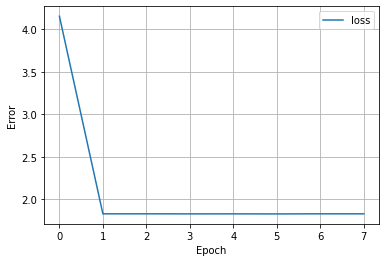

In [17]:
def plot_loss(history):
  plt.plot(history1.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
plot_loss(history1)

In [18]:
#Tensor flow neural network
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

net2 = build_and_compile_model(normalizer1)

history2 = net2.fit(
    np.reshape(x1_train, len(x1_train)).astype(float), np.reshape(y1_train, len(y1_train)).astype(float),
    verbose=1, epochs=8)

Train on 194921 samples
Epoch 1/8
194921/194921 [==============================] - 7s 36us/sample - loss: 2.67452s - l - ET - ETA: 0s - loss: 2.7 - ETA: 0s - loss: 
Epoch 2/8
194921/194921 [==============================] - 7s 34us/sample - loss: 1.2552
Epoch 3/8
194921/194921 [==============================] - 7s 35us/sample - loss: 1.2502
Epoch 4/8
194921/194921 [==============================] - 7s 35us/sample - loss: 1.2475
Epoch 5/8
194921/194921 [==============================] - 7s 35us/sample - loss: 1.24744s - loss: - ETA: 2s  - ETA: 0s - loss: 1. - ETA: 0s -
Epoch 6/8
194921/194921 [==============================] - 7s 36us/sample - loss: 1.2473
Epoch 7/8
194921/194921 [==============================] - 7s 37us/sample - loss: 1.2460
Epoch 8/8
194921/194921 [==============================] - 7s 37us/sample - loss: 1.2456


In [22]:
predict2 = net1.predict((x1_val).astype(float))
predict2 = np.reshape((predict2),len(predict2))
print(MAE(predict2, y1_val))
print(RMSE(predict2, y1_val))

40.92706011513362
47.79864715270067


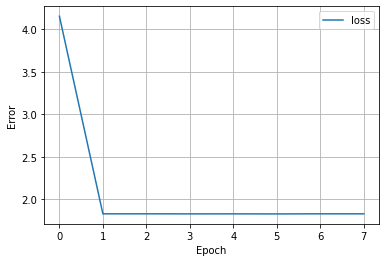

In [20]:
plot_loss(history2)